In [1]:
import pandas as pd
from darts import TimeSeries
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.missing_values import fill_missing_values
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from darts.dataprocessing.transformers import Scaler
from darts.models import TCNModel
from darts.utils.likelihood_models import GaussianLikelihood


# Load the datasets
train_df = pd.read_csv('DailyDelhiClimateTrain.csv', parse_dates=['date'])
test_df = pd.read_csv('DailyDelhiClimateTest.csv', parse_dates=['date'])


<Axes: >

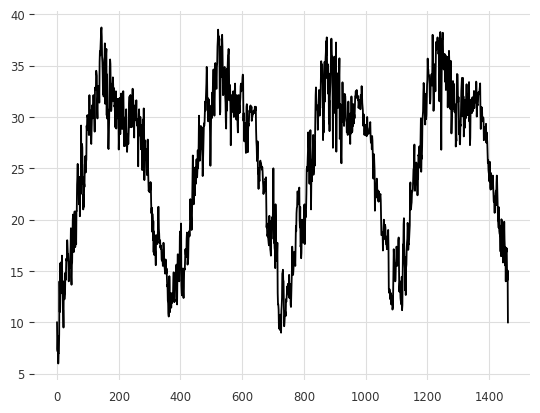

In [2]:
train_df.meantemp.plot()

In [3]:
# Convert to TimeSeries object
temperature_series = TimeSeries.from_dataframe(train_df, 'date', 'meantemp')
#scaling the meantemp data
scaler_ts = Scaler()
temperature_series_transformed = scaler_ts.fit_transform(temperature_series)
# Splitting the data into training and validation sets (80% train, 20% validation)
train_ts, val_ts = temperature_series_transformed.split_after(0.8)

In [4]:
parameters={
    'input_chunk_length':[20,40],
    'output_chunk_length':[5,10],
    'kernel_size':[3,6],
    'num_filters':[3, 6],
    'dilation_base':[2, 4],
    'dropout':[0.1,0.4],
    'likelihood':[GaussianLikelihood()],
    'n_epochs':[10]
}

In [5]:
best_model, best_params, best_metric = TCNModel.gridsearch(
    parameters,
    train_ts,
    forecast_horizon=10,
    verbose=True,
    n_jobs=-1,
    n_random_samples=4,
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Print the evaluation metric for the best model
print("Best Metric:", best_metric)

Best Hyperparameters: {'input_chunk_length': 40, 'output_chunk_length': 5, 'kernel_size': 6, 'num_filters': 6, 'dilation_base': 4, 'dropout': 0.4, 'likelihood': GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0), 'n_epochs': 10}
Best Metric: 45.43060444954427


In [7]:
# Update the 'n_epochs' key in the best_params dictionary
best_params['n_epochs'] = 200

#Create an instance of the best model with the best hyperparameters
best_BasicTCN_model = TCNModel(**best_params)

# Train the best model on the training data
best_BasicTCN_model.fit(train_ts)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 586   
----------------------------------------------------
586       Trainable params
0         Non-trainable params
586       Total params
0.002     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=200` reached.


TCNModel(kernel_size=6, num_filters=6, num_layers=None, dilation_base=4, weight_norm=False, dropout=0.4, input_chunk_length=40, output_chunk_length=5, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0), n_epochs=200)

In [8]:
from darts.metrics import mae, mape
import numpy as np
# Make predictions on the validation set
pred_series = best_BasicTCN_model.predict(len(val_ts))

# Calculate MAE and MAPE
mae_val = mae(val_ts, pred_series)

print(f'MAE on validation data for the most basic one: {mae_val:.4f}')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

MAE on validation data for the most basic one: 0.1895


In [9]:
# Function to determine the season based on the month
def get_season(ts, month):
    if month in [3, 4, 5]:
        return np.float32(0)
    elif month in [6, 7, 8]:
        return np.float32(1)
    elif month in [9, 10, 11]:
        return np.float32(2)
    else:
        return np.float32(3)

month_feature = datetime_attribute_timeseries(temperature_series, attribute='month')
vectorized_get_season = np.vectorize(get_season)
month_feature.map(vectorized_get_season)

# Use get_dummies to one-hot encode the month_feature
season_feature_encoded = pd.get_dummies(month_feature.pd_series(), dtype=np.float32)
# Convert the one-hot encoded DataFrame back to TimeSeries
season_feature_encoded_ts = TimeSeries.from_dataframe(season_feature_encoded, freq='D')

train_future_covariates = datetime_attribute_timeseries(temperature_series, attribute='month', one_hot=True)

concatenated_covariates = train_future_covariates.stack(season_feature_encoded_ts)


# Re-split into training and validation sets
train_future_covariates, val_future_covariates = concatenated_covariates.split_after(0.8)


# Scale the concatenated features if needed
scaler = Scaler()
scaler.fit(train_future_covariates)
concatenated_covariates_scaled = scaler.transform(concatenated_covariates)

# Re-split into training and validation sets
train_future_covariates, val_future_covariates = concatenated_covariates.split_after(0.8)


In [10]:
model_TCNwithCoV = TCNModel(**best_params)
model_TCNwithCoV.fit(train_ts, past_covariates=train_future_covariates, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 1.6 K 
----------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=200` reached.


TCNModel(kernel_size=6, num_filters=6, num_layers=None, dilation_base=4, weight_norm=False, dropout=0.4, input_chunk_length=40, output_chunk_length=5, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0), n_epochs=200)

In [12]:
#streching the covariates enough into the past
train_region = train_future_covariates[pd.Timestamp("2016-02-04 00:00:00") : pd.Timestamp("2016-03-14 00:00:00")]
val_future_covariates = train_region.append(val_future_covariates)


In [13]:
pred_val_cov = model_TCNwithCoV.predict(len(val_ts) , past_covariates=val_future_covariates)
# Calculate MAE with covariates
mae_cov = mean_absolute_error(val_ts.univariate_values(), pred_val_cov.univariate_values())
print(f'MAE on validation data with covariates: {mae_cov}')

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

MAE on validation data with covariates: 0.09335879012882008


In [14]:
# Adding new past covariates to the dataset
past_covariates_columns = ['humidity', 'wind_speed', 'meanpressure']
train_past_covariates = train_df.set_index('date')[past_covariates_columns]

train_past_covariates_ts = TimeSeries.from_dataframe(train_past_covariates)

# Splitting the past covariates into training and validation sets
train_past_covariates, val_past_covariates = train_past_covariates_ts.split_after(0.8)

# Converting to TimeSeries and scaling
scaler_past_cov = Scaler()
scaler_past_cov.fit(train_past_covariates)
train_past_covariates_scaled = scaler_past_cov.transform(train_past_covariates_ts)


In [15]:
train_covariates = train_past_covariates_scaled.stack(concatenated_covariates_scaled)
# Re-split into training and validation sets
train_concated_covariates, val_concated_covariates = train_covariates.split_after(0.8)

In [16]:
parameters['n_epochs']= [10]
best_model_cov, best_params_cov, best_metric_cov = TCNModel.gridsearch(
    parameters=parameters,
    series=train_ts,
    past_covariates=train_concated_covariates,
    forecast_horizon=10,
    verbose=True,
    n_jobs=-1,
    n_random_samples=4
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
# Update the 'n_epochs' key in the best_params dictionary
best_params_cov['n_epochs'] = 100

#Create an instance of the best model with the best hyperparameters
best_model_cov_all = TCNModel(**best_params_cov)

# Train the best model on the training data
best_model_cov_all.fit(series = train_ts, past_covariates=train_concated_covariates, verbose = True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 754   
----------------------------------------------------
754       Trainable params
0         Non-trainable params
754       Total params
0.003     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


TCNModel(kernel_size=6, num_filters=3, num_layers=None, dilation_base=4, weight_norm=False, dropout=0.1, input_chunk_length=20, output_chunk_length=10, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0), n_epochs=100)

In [ ]:
# Concatenate past and future covariates into a single TimeSeries and also streching it enough into the past
val_region = train_concated_covariates[pd.Timestamp("2016-02-24 00:00:00") : pd.Timestamp("2016-03-14 00:00:00")]
val_concated_covariates = val_region.append(val_concated_covariates)
val_covariates = val_concated_covariates.stack(val_concated_covariates)

In [28]:
#Evaluate Model with all the Covariates:
# Make predictions on the validation set with covariates
pred_val_cov_all = best_model_cov_all.predict(len(val_ts), past_covariates = val_concated_covariates)

# Calculate MAE with covariates
mae_cov_all = mean_absolute_error(val_ts.univariate_values(), pred_val_cov_all.univariate_values())
print(f'MAE on validation data with covariates: {mae_cov_all}')

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

MAE on validation data with covariates: 0.18928295481759402


In [29]:

# Define the data
data = {
    '-': [None, 0.1771, 0.36389669274229725, 0.2910, 0.1895],
    'Month and Season': [None, 0.07974285456174764, 0.0820578343738724, 0.07936652404326633, 0.09335879012882008],
    'Mean Pressure and Humidity and Wind Speed': [None, 0.07051171032294203, 0.06876909578028764, 0.061509202640138094, 0.18928295481759402]
}

# Create the DataFrame
end_table = pd.DataFrame(data, index=['Model/Covariates', 'DeepAR', 'N-BEATS', 'TFT', 'TCNModel'])

# Display the DataFrame
end_table


,-,Month and Season,Mean Pressure and Humidity and Wind Speed
Model/Covariates,NaN,NaN,NaN
DeepAR,0.177100,0.079743,0.070512
N-BEATS,0.363897,0.082058,0.068769
TFT,0.291000,0.079367,0.061509
TCNModel,0.189500,0.093359,0.189283
